# Libraries

In [1]:
import torch
import torch.nn as nn
from torchvision.datasets import MNIST
from torchvision.transforms import Compose, ToTensor,Normalize,Lambda
from torch.optim import Adam, SGD
from torch.utils.data import DataLoader, Dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
from tqdm import tqdm
import random
from sklearn.preprocessing import OneHotEncoder
import torch.nn.functional as F
from sklearn.metrics import accuracy_score


# Hyperparameters

In [2]:
batchsize = 1000           # Mini-batch size for efficient training using stochastic gradient descent.
learning_rate = 0.03       # Step size for weight updates during training.
epochs = 100               # Number of passes through the entire dataset during FF learning.
threshold = 3.0            # Threshold value used in the loss function for classification.
image_shape = [28, 28]     # Dimensions of the input images.
layers = [image_shape[0] * image_shape[1], 2000, 2000, 2000, 2000]  # Dimensions of neural network layers.
Input_Layer_LC = [0, 1, 2, 3]  # Indices of hidden layers used as input for the linear classifier.
epochs_LC = 30              # Number of epochs for training the linear classifier.

# Process on the data

In [3]:
def Data_loader():
  # Calculate the mean and standard deviation of the MNIST training dataset
  train_dataset = MNIST('./data/', train=True, download=True, transform=ToTensor())
  train_mean = train_dataset.data.float().mean() / 255.0
  train_std = train_dataset.data.float().std() / 255.0

  # Define the Z-score normalization transformation
  transform = Compose([ToTensor(), Normalize(mean=(train_mean,), std=(train_std,)), Lambda(lambda x: x.view(-1))])

  train_loader = DataLoader(
      MNIST('./data/', train=True, download=True, transform=transform),
      batch_size=batchsize, shuffle=True)

  test_loader = DataLoader(
      MNIST('./data/', train=False, download=True, transform=transform),
      batch_size=2000, shuffle=False)

  return train_loader, test_loader

In [4]:
def y_OneHot(y):
  y = y.numpy().reshape(-1, 1)
  y_hot = torch.Tensor(OneHotEncoder().fit(np.arange(10).reshape((10,1))).transform(y).toarray())

  return y_hot

In [5]:
def y_OneHot_on_x(x, y):
  x_ = x.clone()
  x_[:, :10] = 0.0
  x_[range(x.shape[0]), y] = x.max()

  return x_

## Creating negative data


In [6]:
def get_y_wrong(y):
  # Generate a random tensor of labels
  y_wrong = torch.randint(0, 10, size=y.size(), device=y.device)

  # Find the positions where the random labels match the original labels
  match_positions = (y_wrong == y)

  # Replace these positions with another random choice
  while match_positions.any():
      y_wrong[match_positions] = torch.randint(0, 10, size=(match_positions.sum().item(),), device=y.device)
      match_positions = (y_wrong == y)

  return y_wrong

### Generating masks

In [7]:
def mask_image():
  # Create a random binary mask
  random_mask = (torch.rand(image_shape[0], image_shape[1]) < 0.5).to(torch.float32)  # 0.5 is the threshold

  # Number of blur iterations
  num_iterations = 5  # You can adjust this value

  for _ in range(num_iterations):
    # Apply blurring using a 2D convolution with a [1/4, 1/2, 1/4] filter
    kernel = torch.tensor([[1/4, 1/2, 1/4], [1/2, 1, 1/2], [1/4, 1/2, 1/4]], dtype=torch.float32) /4
    random_mask = F.conv2d(random_mask.unsqueeze(0).unsqueeze(0), kernel.unsqueeze(0).unsqueeze(0), padding=1)
    random_mask = (random_mask > 0.5).squeeze(0).squeeze(0).float()  # Threshold the result
  return random_mask

### Generate hybrid image

In [8]:
def get_neg_data(X):
  mask = mask_image().view(-1)
  hybrid_image = X*mask + X[torch.randperm(X.shape[0])]*(1-mask)
  return hybrid_image


# FF Layer

goodness function is defined as:
$$
g = \frac{1}{M} \sum_{j=1}^{M} y_j^2
$$

The loss function is defined as:

$$
\text{loss} = \frac{1}{N} \sum_{i=1}^{N} \log\left(1 + \exp\left(\text{cat}\left([\text{threshold} - g_{\text{pos},i} , g_{\text{neg},i} - \text{threshold}]\right)\right)\right)
$$

This loss function can satisfy the necessary conditions for a goodness function because:


*   The loss function is designed to penalize deviations from the true class. In this context, the objective is to correctly classify positive and negative data based on the goodness values.

*   The loss function incorporates the threshold value, ensuring that the model aims to correctly classify input vectors as positive or negative based on a threshold.



In [9]:
class FFLayer(nn.Linear):
  def __init__(self, in_features, out_features,
                bias=True, device=None, dtype=None):
    super().__init__(in_features, out_features, bias, device, dtype)
    self.relu = torch.nn.ReLU()
    self.opt = Adam(self.parameters(), lr=learning_rate)
    self.th = threshold


  def forward(self, x):
    # Normalize the input tensor along the second dimension
    x = x.div(x.norm(2, 1, keepdim=True) + 1e-7)

    # Perform a linear transformation
    out = (x.mm(self.weight.T)+self.bias.unsqueeze(0))

    # Apply the ReLU activation function
    return out.relu()

  def train(self, x_pos, x_neg):

    # Forward pass for positive and negative samples, calculate the Goodness fuction
    g_pos = self.forward(x_pos).pow(2).mean(1)
    g_neg = self.forward(x_neg).pow(2).mean(1)

    # Calculate the loss
    loss = torch.mean(torch.log(1 + torch.exp(torch.cat([self.th - g_pos , g_neg - self.th]))))

    # Zero the gradients before running the backward pass
    self.opt.zero_grad()

    # Backward pass: compute gradient of the loss with respect to all the learnable parameters
    loss.backward()

    # Calling the step function on an Optimizer makes an update to its parameters
    self.opt.step()

    # Return the forward pass of the positive and negative samples after training
    return self.forward(x_pos).detach(), self.forward(x_neg).detach()



# FF Network

In [10]:
class FFNet(nn.Module):
  def __init__(self, dims,train_model):
    super().__init__()

    if train_model not in ['UnSupervised', 'Supervised']:
        raise ValueError("train_model must be either 'UnSupervised' or 'Supervised'")
    # Initialize layers of the network based on the provided dimensions
    self.layers = [FFLayer(dims[d], dims[d + 1]).cuda() for d in range(len(dims) - 1)]
    self.train_model=train_model

  def predict(self,x):
    if self.train_model == 'UnSupervised':
      layers_output = torch.Tensor([]).cuda()
      h = x
      for i, layer in enumerate(self.layers):
        h = layer(h)
        if i in Input_Layer_LC:
            layers_output = torch.cat([layers_output,h],1)
      return layers_output
    else:
      # Iitialize list to store goodness of each label
      g_for_labels = []
      # Iteraten over each label
      for label in range(10):
        h = y_OneHot_on_x(x, label)
        goodness = []
        # Pass the input through each layer and calculate goodness
        for layer in self.layers:
            h = layer(h)
            goodness += [h.pow(2).mean(1)]
        # Sum the goodness of all layers for the current label
        g_for_labels += [sum(goodness)]

      # Return the label with the maximum goodness
      return  torch.stack(g_for_labels, dim=1).argmax(dim=1)

  def train(self, x_pos, x_neg):
    out_pos, out_neg = x_pos, x_neg
    for i, layer in enumerate(self.layers):
      out_pos, out_neg = layer.train(out_pos, out_neg)

# Linear Classifier



In [11]:
def Input_dim_LC(layers,Input_Layer_LC):
    return sum(layers[i + 1] for i in Input_Layer_LC)

In [12]:
class LinearClassification(nn.Module):
    def __init__(self, input_dimension):
        super().__init__()
        self.epoch_losses = []
        self.num_epochs = epochs_LC
        self.linear = torch.nn.Linear(input_dimension, 10).cuda()
        self.optimizer = SGD(self.parameters(), lr=learning_rate)
        self.criterion = nn.CrossEntropyLoss()
        self.softmax = nn.Softmax(dim=1)

    def forward(self,x):
        return self.linear(x)

    def predict(self,x):
        x = x.cuda()
        h_activity = net_UN.predict(x)
        y_pred = self.forward(h_activity)

        return self.softmax(y_pred).argmax(dim=-1)


    def train(self, data_loader):
      epoch_loop = tqdm(range(self.num_epochs))
      for i in epoch_loop:
        batch_losses = []
        for batch in iter(data_loader):
          x,y = batch
          x,y = x.cuda(),y_OneHot(y).cuda()
          h_activity = net_UN.predict(x)
          y_pred = self.forward(h_activity)
          loss = self.criterion(y_pred,y)
          self.optimizer.zero_grad()
          loss.backward()
          self.optimizer.step()
          batch_losses.append(loss)

        self.epoch_losses.append(float(sum(batch_losses)/len(batch_losses)))
        epoch_loop.set_description(f"Epoch [{i+1}/{self.num_epochs}]: ")
        epoch_loop.set_postfix(loss=self.epoch_losses[i])


# Training the FF Network

## Supervised learning

In [13]:
#Load data
torch.manual_seed(1234)
train_data, test_data = Data_loader()

# Create network
net_SU = FFNet(layers,'Supervised')

for epoch in range(epochs):
  num_corrects=0
  for (x, y) in tqdm(train_data, leave=True):
    x, y = x.cuda(), y.cuda()
    x_pos = y_OneHot_on_x(x, y)
    x_neg = y_OneHot_on_x(x, get_y_wrong(y))

    # Train the network
    net_SU.train(x_pos, x_neg)
    y_pred = net_SU.predict(x).cpu().numpy()
    num_corrects += (y_pred == y.cpu().numpy()).sum()
  print(f'Epoch {epoch}, Accuracy: {(num_corrects / 60000):.2f}')



100%|██████████| 9912422/9912422 [00:00<00:00, 141962519.27it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 27815314.31it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 208009245.57it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 20053188.18it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 60/60 [00:32<00:00,  1.87it/s]


Epoch 0, Accuracy: 0.11


100%|██████████| 60/60 [00:20<00:00,  2.96it/s]


Epoch 1, Accuracy: 0.11


100%|██████████| 60/60 [00:20<00:00,  2.89it/s]


Epoch 2, Accuracy: 0.29


100%|██████████| 60/60 [00:20<00:00,  2.97it/s]


Epoch 3, Accuracy: 0.47


100%|██████████| 60/60 [00:23<00:00,  2.60it/s]


Epoch 4, Accuracy: 0.63


100%|██████████| 60/60 [00:21<00:00,  2.84it/s]


Epoch 5, Accuracy: 0.75


100%|██████████| 60/60 [00:20<00:00,  2.88it/s]


Epoch 6, Accuracy: 0.83


100%|██████████| 60/60 [00:21<00:00,  2.82it/s]


Epoch 7, Accuracy: 0.86


100%|██████████| 60/60 [00:20<00:00,  2.91it/s]


Epoch 8, Accuracy: 0.88


100%|██████████| 60/60 [00:21<00:00,  2.81it/s]


Epoch 9, Accuracy: 0.89


100%|██████████| 60/60 [00:20<00:00,  2.93it/s]


Epoch 10, Accuracy: 0.90


100%|██████████| 60/60 [00:21<00:00,  2.82it/s]


Epoch 11, Accuracy: 0.90


100%|██████████| 60/60 [00:20<00:00,  2.93it/s]


Epoch 12, Accuracy: 0.91


100%|██████████| 60/60 [00:21<00:00,  2.76it/s]


Epoch 13, Accuracy: 0.91


100%|██████████| 60/60 [00:20<00:00,  2.87it/s]


Epoch 14, Accuracy: 0.91


100%|██████████| 60/60 [00:22<00:00,  2.71it/s]


Epoch 15, Accuracy: 0.91


100%|██████████| 60/60 [00:20<00:00,  2.87it/s]


Epoch 16, Accuracy: 0.91


100%|██████████| 60/60 [00:21<00:00,  2.80it/s]


Epoch 17, Accuracy: 0.91


100%|██████████| 60/60 [00:20<00:00,  2.91it/s]


Epoch 18, Accuracy: 0.92


100%|██████████| 60/60 [00:21<00:00,  2.81it/s]


Epoch 19, Accuracy: 0.92


100%|██████████| 60/60 [00:21<00:00,  2.85it/s]


Epoch 20, Accuracy: 0.92


100%|██████████| 60/60 [00:20<00:00,  2.86it/s]


Epoch 21, Accuracy: 0.92


100%|██████████| 60/60 [00:20<00:00,  2.86it/s]


Epoch 22, Accuracy: 0.93


100%|██████████| 60/60 [00:20<00:00,  2.91it/s]


Epoch 23, Accuracy: 0.93


100%|██████████| 60/60 [00:21<00:00,  2.83it/s]


Epoch 24, Accuracy: 0.93


100%|██████████| 60/60 [00:20<00:00,  2.96it/s]


Epoch 25, Accuracy: 0.93


100%|██████████| 60/60 [00:21<00:00,  2.80it/s]


Epoch 26, Accuracy: 0.93


100%|██████████| 60/60 [00:20<00:00,  2.95it/s]


Epoch 27, Accuracy: 0.93


100%|██████████| 60/60 [00:21<00:00,  2.85it/s]


Epoch 28, Accuracy: 0.94


100%|██████████| 60/60 [00:20<00:00,  2.99it/s]


Epoch 29, Accuracy: 0.94


100%|██████████| 60/60 [00:20<00:00,  2.87it/s]


Epoch 30, Accuracy: 0.94


100%|██████████| 60/60 [00:20<00:00,  2.96it/s]


Epoch 31, Accuracy: 0.94


100%|██████████| 60/60 [00:21<00:00,  2.84it/s]


Epoch 32, Accuracy: 0.94


100%|██████████| 60/60 [00:20<00:00,  2.99it/s]


Epoch 33, Accuracy: 0.94


100%|██████████| 60/60 [00:21<00:00,  2.76it/s]


Epoch 34, Accuracy: 0.94


100%|██████████| 60/60 [00:20<00:00,  2.95it/s]


Epoch 35, Accuracy: 0.94


100%|██████████| 60/60 [00:25<00:00,  2.34it/s]


Epoch 36, Accuracy: 0.94


100%|██████████| 60/60 [00:20<00:00,  2.96it/s]


Epoch 37, Accuracy: 0.94


100%|██████████| 60/60 [00:20<00:00,  2.88it/s]


Epoch 38, Accuracy: 0.95


100%|██████████| 60/60 [00:20<00:00,  2.96it/s]


Epoch 39, Accuracy: 0.95


100%|██████████| 60/60 [00:21<00:00,  2.80it/s]


Epoch 40, Accuracy: 0.95


100%|██████████| 60/60 [00:19<00:00,  3.00it/s]


Epoch 41, Accuracy: 0.95


100%|██████████| 60/60 [00:20<00:00,  2.87it/s]


Epoch 42, Accuracy: 0.95


100%|██████████| 60/60 [00:20<00:00,  2.98it/s]


Epoch 43, Accuracy: 0.95


100%|██████████| 60/60 [00:20<00:00,  2.87it/s]


Epoch 44, Accuracy: 0.95


100%|██████████| 60/60 [00:20<00:00,  2.92it/s]


Epoch 45, Accuracy: 0.95


100%|██████████| 60/60 [00:20<00:00,  2.87it/s]


Epoch 46, Accuracy: 0.95


100%|██████████| 60/60 [00:20<00:00,  2.93it/s]


Epoch 47, Accuracy: 0.95


100%|██████████| 60/60 [00:20<00:00,  2.92it/s]


Epoch 48, Accuracy: 0.95


100%|██████████| 60/60 [00:20<00:00,  2.88it/s]


Epoch 49, Accuracy: 0.95


100%|██████████| 60/60 [00:20<00:00,  2.91it/s]


Epoch 50, Accuracy: 0.95


100%|██████████| 60/60 [00:20<00:00,  2.94it/s]


Epoch 51, Accuracy: 0.96


100%|██████████| 60/60 [00:21<00:00,  2.80it/s]


Epoch 52, Accuracy: 0.96


100%|██████████| 60/60 [00:20<00:00,  2.97it/s]


Epoch 53, Accuracy: 0.96


100%|██████████| 60/60 [00:20<00:00,  2.89it/s]


Epoch 54, Accuracy: 0.96


100%|██████████| 60/60 [00:20<00:00,  2.97it/s]


Epoch 55, Accuracy: 0.96


100%|██████████| 60/60 [00:20<00:00,  2.91it/s]


Epoch 56, Accuracy: 0.96


100%|██████████| 60/60 [00:19<00:00,  3.00it/s]


Epoch 57, Accuracy: 0.96


100%|██████████| 60/60 [00:20<00:00,  2.88it/s]


Epoch 58, Accuracy: 0.96


100%|██████████| 60/60 [00:19<00:00,  3.00it/s]


Epoch 59, Accuracy: 0.96


100%|██████████| 60/60 [00:21<00:00,  2.85it/s]


Epoch 60, Accuracy: 0.96


100%|██████████| 60/60 [00:20<00:00,  3.00it/s]


Epoch 61, Accuracy: 0.96


100%|██████████| 60/60 [00:20<00:00,  2.90it/s]


Epoch 62, Accuracy: 0.96


100%|██████████| 60/60 [00:20<00:00,  2.97it/s]


Epoch 63, Accuracy: 0.96


100%|██████████| 60/60 [00:20<00:00,  2.89it/s]


Epoch 64, Accuracy: 0.96


100%|██████████| 60/60 [00:20<00:00,  2.96it/s]


Epoch 65, Accuracy: 0.96


100%|██████████| 60/60 [00:20<00:00,  2.87it/s]


Epoch 66, Accuracy: 0.96


100%|██████████| 60/60 [00:20<00:00,  2.96it/s]


Epoch 67, Accuracy: 0.96


100%|██████████| 60/60 [00:20<00:00,  2.88it/s]


Epoch 68, Accuracy: 0.96


100%|██████████| 60/60 [00:20<00:00,  2.93it/s]


Epoch 69, Accuracy: 0.96


100%|██████████| 60/60 [00:20<00:00,  2.86it/s]


Epoch 70, Accuracy: 0.96


100%|██████████| 60/60 [00:21<00:00,  2.83it/s]


Epoch 71, Accuracy: 0.96


100%|██████████| 60/60 [00:21<00:00,  2.85it/s]


Epoch 72, Accuracy: 0.97


100%|██████████| 60/60 [00:20<00:00,  2.99it/s]


Epoch 73, Accuracy: 0.97


100%|██████████| 60/60 [00:20<00:00,  2.87it/s]


Epoch 74, Accuracy: 0.97


100%|██████████| 60/60 [00:20<00:00,  2.97it/s]


Epoch 75, Accuracy: 0.97


100%|██████████| 60/60 [00:21<00:00,  2.85it/s]


Epoch 76, Accuracy: 0.97


100%|██████████| 60/60 [00:19<00:00,  3.01it/s]


Epoch 77, Accuracy: 0.97


100%|██████████| 60/60 [00:20<00:00,  2.87it/s]


Epoch 78, Accuracy: 0.97


100%|██████████| 60/60 [00:20<00:00,  2.97it/s]


Epoch 79, Accuracy: 0.97


100%|██████████| 60/60 [00:20<00:00,  2.89it/s]


Epoch 80, Accuracy: 0.97


100%|██████████| 60/60 [00:20<00:00,  2.99it/s]


Epoch 81, Accuracy: 0.97


100%|██████████| 60/60 [00:20<00:00,  2.87it/s]


Epoch 82, Accuracy: 0.97


100%|██████████| 60/60 [00:19<00:00,  3.00it/s]


Epoch 83, Accuracy: 0.97


100%|██████████| 60/60 [00:20<00:00,  2.90it/s]


Epoch 84, Accuracy: 0.97


100%|██████████| 60/60 [00:20<00:00,  2.97it/s]


Epoch 85, Accuracy: 0.97


100%|██████████| 60/60 [00:20<00:00,  2.87it/s]


Epoch 86, Accuracy: 0.97


100%|██████████| 60/60 [00:19<00:00,  3.01it/s]


Epoch 87, Accuracy: 0.97


100%|██████████| 60/60 [00:20<00:00,  2.87it/s]


Epoch 88, Accuracy: 0.97


100%|██████████| 60/60 [00:20<00:00,  2.93it/s]


Epoch 89, Accuracy: 0.97


100%|██████████| 60/60 [00:21<00:00,  2.80it/s]


Epoch 90, Accuracy: 0.97


100%|██████████| 60/60 [00:20<00:00,  2.99it/s]


Epoch 91, Accuracy: 0.97


100%|██████████| 60/60 [00:20<00:00,  2.87it/s]


Epoch 92, Accuracy: 0.97


100%|██████████| 60/60 [00:20<00:00,  3.00it/s]


Epoch 93, Accuracy: 0.97


100%|██████████| 60/60 [00:21<00:00,  2.85it/s]


Epoch 94, Accuracy: 0.97


100%|██████████| 60/60 [00:20<00:00,  2.98it/s]


Epoch 95, Accuracy: 0.97


100%|██████████| 60/60 [00:25<00:00,  2.38it/s]


Epoch 96, Accuracy: 0.97


100%|██████████| 60/60 [00:20<00:00,  2.97it/s]


Epoch 97, Accuracy: 0.97


100%|██████████| 60/60 [00:20<00:00,  2.93it/s]


Epoch 98, Accuracy: 0.97


100%|██████████| 60/60 [00:20<00:00,  2.97it/s]

Epoch 99, Accuracy: 0.97


In [14]:
def get_accuracy(data,Net_model):
  data_loop=iter(data)
  list_acc=[]
  for batch in data_loop:
    x,y=batch
    x,y=x.cuda(),y.cuda()
    y_pred=Net_model.predict(x).cpu().numpy()
    list_acc.append(accuracy_score(y.cpu().numpy(), y_pred) * 100)
  return(float(sum(list_acc)/len(list_acc)))

## Accuracy for Supervised Learning

In [15]:
# Accuracy on the train dataset
print(f'Accuracy on the train dataset (Supervised): {get_accuracy(train_data,net_SU):.2f}')

# Accuracy on the test dataset
print(f'Accuracy on the test dataset (Supervised): {get_accuracy(test_data,net_SU):.2f}')

Accuracy on the train dataset (Supervised): 97.31
Accuracy on the test dataset (Supervised): 96.41


## UnSupervised learning



**Why use Unsupervised learning?**
*   **Output of the Unsupervised FF Network**

  The unsupervised FF network is trained to learn effective multi-layer representations without using any label information.The key aspect of the training is the use of positive examples (real data vectors) and negative examples (corrupted data vectors) to encourage the network to capture the structure in the data.

*   **Relationship to Labels**

  The output of the unsupervised FF network, particularly the normalized activity vectors of the last three hidden layers, serves as a representation of the input data. These representations are not directly related to labels during the unsupervised training phase. The aim of this phase is to learn features and representations that capture long-range correlations in the images, such as shapes, without any explicit knowledge of the labels.

* **Transition to Linear Classifier**

  To relate the learned representations to labels, a linear classifier is introduced. This classifier takes the normalized activity vectors of the last four hidden layers as inputs and is trained to predict the corresponding labels. The transition involves transforming the unsupervised representations into a format suitable for supervised learning.


**Why Use a Linear Classifier?**

 * **Linear Separability**

   Linear classifiers are used because they are computationally efficient and work well when the learned representations are linearly separable concerning the labels. The decision boundary in the feature space is a hyperplane.

* **Contrastive Learning**

  The use of negative examples in the unsupervised training phase creates a contrastive learning scenario. The representations learned by the network should be such that positive and negative examples are distinguishable. A linear classifier is well-suited to exploit these learned features for label prediction.



In [16]:
# Create network
net_UN = FFNet(layers,train_model='UnSupervised')
train_data, test_data = Data_loader()

for epoch in range(epochs):
  for (x, _) in tqdm(train_data, leave=True):
    x_pos = x
    x_neg = get_neg_data(x_pos)
    x_pos, x_neg = x_pos.cuda(), x_neg.cuda()
    # Train the network
    net_UN.train(x_pos, x_neg)
  print(f'Epoch {epoch}')





100%|██████████| 60/60 [00:13<00:00,  4.40it/s]


Epoch 0


100%|██████████| 60/60 [00:13<00:00,  4.43it/s]


Epoch 1


100%|██████████| 60/60 [00:13<00:00,  4.41it/s]


Epoch 2


100%|██████████| 60/60 [00:13<00:00,  4.44it/s]


Epoch 3


100%|██████████| 60/60 [00:13<00:00,  4.42it/s]


Epoch 4


100%|██████████| 60/60 [00:13<00:00,  4.39it/s]


Epoch 5


100%|██████████| 60/60 [00:13<00:00,  4.38it/s]


Epoch 6


100%|██████████| 60/60 [00:13<00:00,  4.35it/s]


Epoch 7


100%|██████████| 60/60 [00:13<00:00,  4.35it/s]


Epoch 8


100%|██████████| 60/60 [00:13<00:00,  4.37it/s]


Epoch 9


100%|██████████| 60/60 [00:14<00:00,  4.13it/s]


Epoch 10


100%|██████████| 60/60 [00:13<00:00,  4.36it/s]


Epoch 11


100%|██████████| 60/60 [00:13<00:00,  4.42it/s]


Epoch 12


100%|██████████| 60/60 [00:13<00:00,  4.38it/s]


Epoch 13


100%|██████████| 60/60 [00:13<00:00,  4.39it/s]


Epoch 14


100%|██████████| 60/60 [00:13<00:00,  4.40it/s]


Epoch 15


100%|██████████| 60/60 [00:13<00:00,  4.40it/s]


Epoch 16


100%|██████████| 60/60 [00:13<00:00,  4.37it/s]


Epoch 17


100%|██████████| 60/60 [00:13<00:00,  4.40it/s]


Epoch 18


100%|██████████| 60/60 [00:13<00:00,  4.46it/s]


Epoch 19


100%|██████████| 60/60 [00:13<00:00,  4.36it/s]


Epoch 20


100%|██████████| 60/60 [00:13<00:00,  4.42it/s]


Epoch 21


100%|██████████| 60/60 [00:13<00:00,  4.42it/s]


Epoch 22


100%|██████████| 60/60 [00:13<00:00,  4.44it/s]


Epoch 23


100%|██████████| 60/60 [00:13<00:00,  4.34it/s]


Epoch 24


100%|██████████| 60/60 [00:13<00:00,  4.44it/s]


Epoch 25


100%|██████████| 60/60 [00:13<00:00,  4.41it/s]


Epoch 26


100%|██████████| 60/60 [00:13<00:00,  4.38it/s]


Epoch 27


100%|██████████| 60/60 [00:13<00:00,  4.46it/s]


Epoch 28


100%|██████████| 60/60 [00:13<00:00,  4.38it/s]


Epoch 29


100%|██████████| 60/60 [00:13<00:00,  4.46it/s]


Epoch 30


100%|██████████| 60/60 [00:13<00:00,  4.39it/s]


Epoch 31


100%|██████████| 60/60 [00:13<00:00,  4.42it/s]


Epoch 32


100%|██████████| 60/60 [00:13<00:00,  4.35it/s]


Epoch 33


100%|██████████| 60/60 [00:13<00:00,  4.41it/s]


Epoch 34


100%|██████████| 60/60 [00:13<00:00,  4.42it/s]


Epoch 35


100%|██████████| 60/60 [00:13<00:00,  4.38it/s]


Epoch 36


100%|██████████| 60/60 [00:13<00:00,  4.39it/s]


Epoch 37


100%|██████████| 60/60 [00:15<00:00,  3.99it/s]


Epoch 38


100%|██████████| 60/60 [00:13<00:00,  4.38it/s]


Epoch 39


100%|██████████| 60/60 [00:13<00:00,  4.36it/s]


Epoch 40


100%|██████████| 60/60 [00:13<00:00,  4.34it/s]


Epoch 41


100%|██████████| 60/60 [00:13<00:00,  4.32it/s]


Epoch 42


100%|██████████| 60/60 [00:13<00:00,  4.43it/s]


Epoch 43


100%|██████████| 60/60 [00:13<00:00,  4.34it/s]


Epoch 44


100%|██████████| 60/60 [00:13<00:00,  4.39it/s]


Epoch 45


100%|██████████| 60/60 [00:13<00:00,  4.35it/s]


Epoch 46


100%|██████████| 60/60 [00:13<00:00,  4.46it/s]


Epoch 47


100%|██████████| 60/60 [00:13<00:00,  4.42it/s]


Epoch 48


100%|██████████| 60/60 [00:13<00:00,  4.38it/s]


Epoch 49


100%|██████████| 60/60 [00:13<00:00,  4.41it/s]


Epoch 50


100%|██████████| 60/60 [00:13<00:00,  4.40it/s]


Epoch 51


100%|██████████| 60/60 [00:13<00:00,  4.42it/s]


Epoch 52


100%|██████████| 60/60 [00:13<00:00,  4.37it/s]


Epoch 53


100%|██████████| 60/60 [00:13<00:00,  4.42it/s]


Epoch 54


100%|██████████| 60/60 [00:13<00:00,  4.39it/s]


Epoch 55


100%|██████████| 60/60 [00:13<00:00,  4.41it/s]


Epoch 56


100%|██████████| 60/60 [00:13<00:00,  4.38it/s]


Epoch 57


100%|██████████| 60/60 [00:13<00:00,  4.35it/s]


Epoch 58


100%|██████████| 60/60 [00:13<00:00,  4.43it/s]


Epoch 59


100%|██████████| 60/60 [00:13<00:00,  4.39it/s]


Epoch 60


100%|██████████| 60/60 [00:13<00:00,  4.37it/s]


Epoch 61


100%|██████████| 60/60 [00:13<00:00,  4.38it/s]


Epoch 62


100%|██████████| 60/60 [00:13<00:00,  4.33it/s]


Epoch 63


100%|██████████| 60/60 [00:13<00:00,  4.39it/s]


Epoch 64


100%|██████████| 60/60 [00:14<00:00,  4.15it/s]


Epoch 65


100%|██████████| 60/60 [00:13<00:00,  4.39it/s]


Epoch 66


100%|██████████| 60/60 [00:13<00:00,  4.44it/s]


Epoch 67


100%|██████████| 60/60 [00:13<00:00,  4.38it/s]


Epoch 68


100%|██████████| 60/60 [00:13<00:00,  4.39it/s]


Epoch 69


100%|██████████| 60/60 [00:13<00:00,  4.42it/s]


Epoch 70


100%|██████████| 60/60 [00:13<00:00,  4.44it/s]


Epoch 71


100%|██████████| 60/60 [00:13<00:00,  4.47it/s]


Epoch 72


100%|██████████| 60/60 [00:13<00:00,  4.39it/s]


Epoch 73


100%|██████████| 60/60 [00:13<00:00,  4.35it/s]


Epoch 74


100%|██████████| 60/60 [00:13<00:00,  4.43it/s]


Epoch 75


100%|██████████| 60/60 [00:13<00:00,  4.42it/s]


Epoch 76


100%|██████████| 60/60 [00:13<00:00,  4.39it/s]


Epoch 77


100%|██████████| 60/60 [00:13<00:00,  4.47it/s]


Epoch 78


100%|██████████| 60/60 [00:13<00:00,  4.39it/s]


Epoch 79


100%|██████████| 60/60 [00:13<00:00,  4.43it/s]


Epoch 80


100%|██████████| 60/60 [00:13<00:00,  4.47it/s]


Epoch 81


100%|██████████| 60/60 [00:13<00:00,  4.44it/s]


Epoch 82


100%|██████████| 60/60 [00:13<00:00,  4.40it/s]


Epoch 83


100%|██████████| 60/60 [00:13<00:00,  4.42it/s]


Epoch 84


100%|██████████| 60/60 [00:13<00:00,  4.44it/s]


Epoch 85


100%|██████████| 60/60 [00:13<00:00,  4.38it/s]


Epoch 86


100%|██████████| 60/60 [00:13<00:00,  4.43it/s]


Epoch 87


100%|██████████| 60/60 [00:13<00:00,  4.30it/s]


Epoch 88


100%|██████████| 60/60 [00:13<00:00,  4.47it/s]


Epoch 89


100%|██████████| 60/60 [00:13<00:00,  4.39it/s]


Epoch 90


100%|██████████| 60/60 [00:13<00:00,  4.29it/s]


Epoch 91


100%|██████████| 60/60 [00:13<00:00,  4.34it/s]


Epoch 92


100%|██████████| 60/60 [00:14<00:00,  4.03it/s]


Epoch 93


100%|██████████| 60/60 [00:13<00:00,  4.39it/s]


Epoch 94


100%|██████████| 60/60 [00:13<00:00,  4.42it/s]


Epoch 95


100%|██████████| 60/60 [00:13<00:00,  4.41it/s]


Epoch 96


100%|██████████| 60/60 [00:13<00:00,  4.45it/s]


Epoch 97


100%|██████████| 60/60 [00:13<00:00,  4.39it/s]


Epoch 98


100%|██████████| 60/60 [00:13<00:00,  4.39it/s]

Epoch 99


In [17]:
# Train linear Classifier
LC = LinearClassification(Input_dim_LC(layers,Input_Layer_LC))
LC.train(train_data)

Epoch [30/30]: : 100%|██████████| 30/30 [06:23<00:00, 12.80s/it, loss=0.0424]


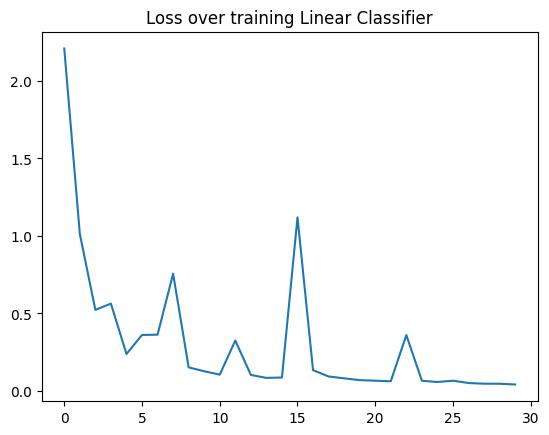

In [18]:
plt.plot(LC.epoch_losses)
plt.title("Loss over training Linear Classifier")
plt.show()

## Accuracy for UnSupervised Learning

In [19]:
# Accuracy on the train dataset
print(f'Accuracy on the train dataset (UnSupervised): {get_accuracy(train_data,LC):.2f}')

# Accuracy on the test dataset
print(f'Accuracy on the test dataset (UnSupervised): {get_accuracy(test_data,LC):.2f}')

Accuracy on the train dataset (UnSupervised): 99.00
Accuracy on the test dataset (UnSupervised): 97.33
